In [15]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest, levene

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [16]:
# antes de empezar vamos a leer los datos, con el método .read_csv
#tmb usamos el método .head(1) para ver la primera fila
df = pd.read_csv("df_union.csv")
df.head(1)

,loyalty_number,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,100018,157,35,192,50682,5376.0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN


# Evaluación de Diferencias en Reservas
# de Vuelos por Nivel Educativo

# 1. Preparación de datos

In [3]:
# 1º creo un dataframe con las columnas que necesito para el análisis
df_analisis = df[['flights_booked', 'education']]
df_analisis

,flights_booked,education
0,157,Bachelor
1,173,College
2,152,College
3,79,Bachelor
4,127,Bachelor
...,...,...
16732,178,College
16733,0,Doctor
16734,63,Bachelor
16735,22,College


# 2. Análisis descriptivo

In [4]:
media_por_nivel = df_analisis.groupby('education')['flights_booked'].mean()

print(media_por_nivel)

education
Bachelor                 99.104821
College                 100.613025
Doctor                  100.866485
High School or Below    101.014066
Master                  101.602362
Name: flights_booked, dtype: float64


In [5]:
desviacion_estandar_por_nivel = df_analisis.groupby('education')['flights_booked'].std()

print(desviacion_estandar_por_nivel)

education
Bachelor                54.231557
College                 54.208810
Doctor                  55.933391
High School or Below    54.867491
Master                  54.023146
Name: flights_booked, dtype: float64


In [6]:
percentile_25_75 = np.percentile(df_analisis['flights_booked'], [25, 75, 100])

print(percentile_25_75)

[ 60. 139. 354.]


In [7]:
df_analisis.describe().T

,count,mean,std,min,25%,50%,75%,max
flights_booked,16737.0,99.728984,54.324783,0.0,60.0,113.0,139.0,354.0


In [8]:
df_analisis.describe(include = 'O').T

,count,unique,top,freq
education,16737,5,Bachelor,10475


In [9]:
df_analisis0 = df_analisis.groupby("education")["flights_booked"].sum().reset_index()
df_analisis0

,education,flights_booked
0,Bachelor,1038123
1,College,426398
2,Doctor,74036
3,High School or Below,78993
4,Master,51614


# 3. Prueba Estadística

In [10]:
# Establecemos la hipótesis nula (H0): No existe una diferencia significativa en el número de vuelos reservados por los 
# diferentes niveles educativos.
# Establecemos la hipótesis alternativa (H1): Sí existe una diferencia significativa en el número de vuelos reservados
# por los diferentes niveles educativos

primero vemos que cumpla las condiciones de normalidad, homogeneidad de varianzas e independencia

<Axes: xlabel='flights_booked', ylabel='Count'>

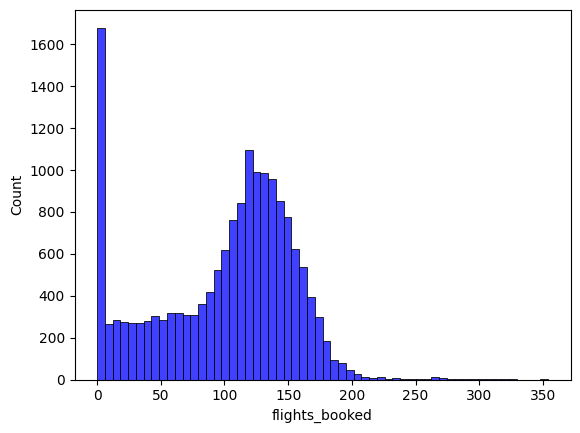

In [11]:
# realizo un histograma para de una forma visual ver la distribución de la muestra.
sns.histplot(data =df_analisis, x = 'flights_booked', kde = False, color = 'blue')

In [12]:
# realizo el test de Shapiro-Wilk para evaluar si los datos siguen una distribución normal.
def normalidad(dataframe, columna):
    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal(p-value =", p_value, ")")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal(p-value =", p_value, ")")

In [13]:
normalidad(df_analisis, 'flights_booked')

Para la columna flights_booked los datos no siguen una distribución normal(p-value = 3.776878515364204e-63 )


In [14]:
# realizo el test de Levene para determinar la homogeneidad de las varianzas

def homogeneidad (dataframe, columna, columna_metrica):
    
    """
    Evalúa la homogeneidad de las varianzas entre grupos para una métrica específica en un DataFrame dado.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que contiene los datos.
    - columna (str): El nombre de la columna que se utilizará para dividir los datos en grupos.
    - columna_metrica (str): El nombre de la columna que se utilizará para evaluar la homogeneidad de las varianzas.

    Returns:
    No devuelve nada directamente, pero imprime en la consola si las varianzas son homogéneas o no entre los grupos.
    Se utiliza la prueba de Levene para evaluar la homogeneidad de las varianzas. Si el valor p resultante es mayor que 0.05,
    se concluye que las varianzas son homogéneas; de lo contrario, se concluye que las varianzas no son homogéneas.
    """
    
    # lo primero que tenemos que hacer es crear tantos conjuntos de datos para cada una de las categorías que tenemos, Control Campaign y Test Campaign
    valores_evaluar = []
    
    for valor in dataframe[columna].unique():
        valores_evaluar.append(dataframe[dataframe[columna]== valor][columna_metrica])

    statistic, p_value = stats.levene(*valores_evaluar)
    if p_value > 0.05:
        print(f"Para la métrica {columna_metrica} las varianzas son homogéneas entre grupos.")
    else:
        print(f"Para la métrica {columna_metrica}, las varianzas no son homogéneas entre grupos.")
